In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage as sk
from scipy import ndimage as ndi

from skimage import exposure
from skimage import io
from skimage import feature
from skimage import filters
from skimage import morphology


# for HEQ
from skimage.filters import rank
from skimage.morphology import disk
from skimage.feature import peak_local_max

%matplotlib inline

In [2]:
img_file = '/Users/kpuhger/Box Sync/count_cellula_imgs/SampleGFP.tif'
img = sk.io.imread(img_file)

In [3]:
img.shape

(15, 572, 702)

### Convenience function for plotting histogram and image together

In [4]:
def img_hist_single(image):

    f, ax = plt.subplots(ncols=2, figsize=(20,10));
    ax[0].hist(image.ravel(), bins=256)
    ax[1].imshow(image, cmap='gray')
    
def img_hist_stack(image, stack):

    f, ax = plt.subplots(ncols=2, figsize=(20,10));
    ax[0].hist(image[stack,:, :].ravel(), bins=256)
    ax[1].imshow(image[stack,:, :], cmap='gray')    

In [5]:
# f, ax = plt.subplots(1,1, figsize=(20,20))
# ax.imshow(img[9, :, :], cmap='gray');

In [7]:
# test_img = img[9, :, :]
# plt.hist(test_img.ravel(), bins=256);

In [8]:
def gaussian_blur(image, sigma):
    # must convert image to float for this to work in a loop (unknown reason)
    image = (image*1.0)/np.max(image)
    img_gaussian = np.empty_like(image)
    for i in range(len(image)):
        img_gaussian[i,:,:] = filters.gaussian(image[i,:,:], sigma)
    return img_gaussian

In [10]:
# test_blur_stack = gaussian_blur(img, 5)
# test_blur_single = test_blur_stack[9, :, :]
# plt.hist(test_blur_single.ravel(), bins=256);

# Comparing HEQ methods

## Local equalization

In [11]:
# img_rank_eq = rank.equalize(test_blur_single, selem=disk(5000))

# img_hist_single(img_rank_eq)

In [12]:
def local_eq(img, selem=disk(5000), **kwargs):
    """
    Equalize image using local (user-defined) histogram

    An algorithm for local contrast enhancement, that uses histograms computed over different tile regions of the image. 
    Local details can therefore be enhanced even in regions that are darker or lighter than most of the image.
    
    ------------
    Parameters:
    ------------
    mage : 2-D array (uint8, uint16)
        Input image.
    
    selem : 2-D array
        The neighborhood expressed as a 2-D array of 1's and 0's.
    
    out : 2-D array (same dtype as input)
        If None, a new array is allocated.
    
    mask : ndarray
        Mask array that defines (>0) area of the image included in the local
        neighborhood. If None, the complete image is used (default).
    
    shift_x, shift_y : int
        Offset added to the structuring element center point. Shift is bounded
        to the structuring element sizes (center must be inside the given
        structuring element).  
                
    ------------  
    Returns:
    ------------  
    out: (M, N[,C]) ndarray
        output image
    
    
    ------------
    Notes:
    ------------
    - For color images, the following steps are performed:
        - The image is converted to HSV color space
        - The CLAHE algorithm is run on the V (Value) channel
        - The image is converted back to RGB space and returned
    
    
    ------------
    References:
    ------------
    [1]: http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist
    [2]: http://en.wikipedia.org/wiki/Histogram_equalization


    """
    

    img_local_eq = np.empty_like(img)
    for z in range(len(img)):
        img_local_eq[z, :, :] = rank.equalize(img[z, :, :], selem)

    return img_local_eq

In [14]:
leq_test = local_eq(test_blur_stack)

/Users/KPuhger/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


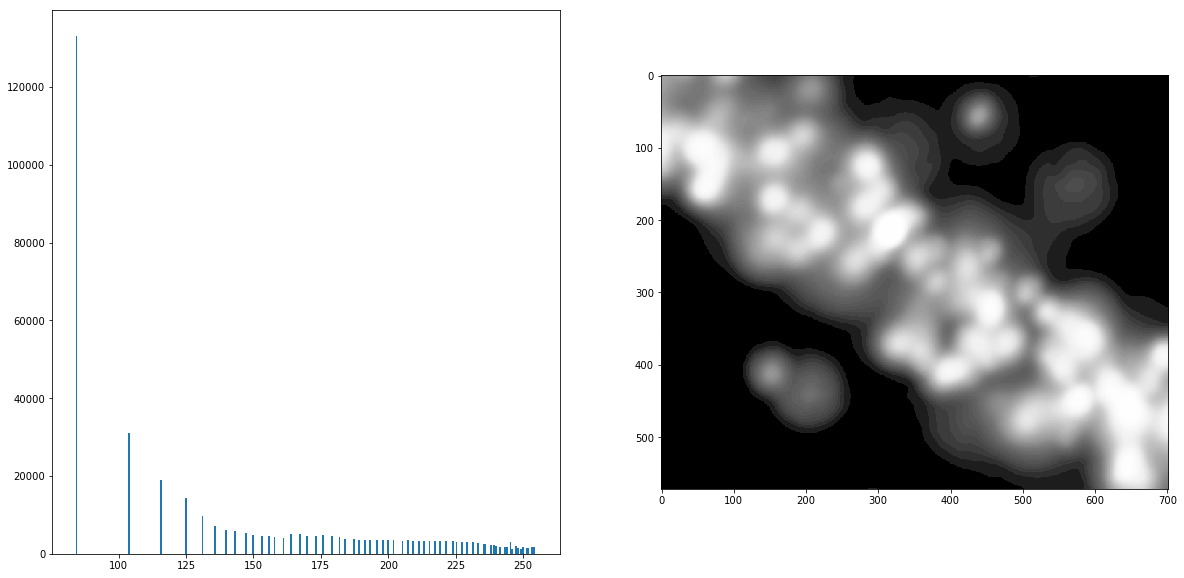

In [16]:
# img_hist_stack(leq_test, 9)

## Contrast stretch -- done

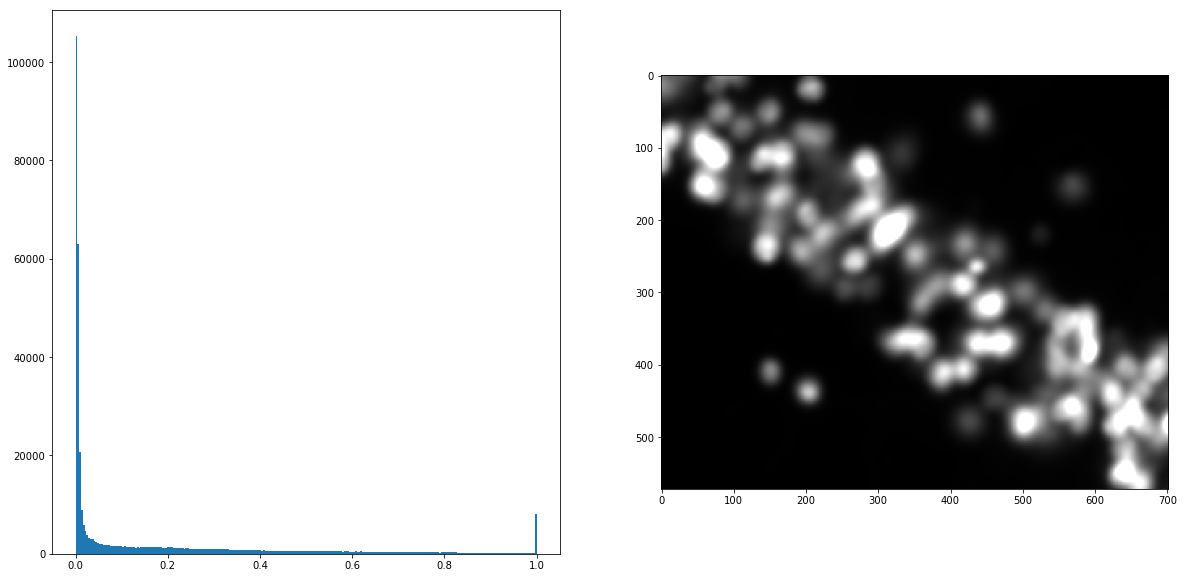

In [10]:
# p2, p98 = np.percentile(test_blur_single, (2, 98))
# img_rescale = exposure.rescale_intensity(test_blur_single, in_range=(p2, p98))

# img_hist_single(img_rescale)

In [25]:
# eq - histogram-based equalization

def contrast_stretch(img, p1=2, p2=98, **kwargs):
    """
    intensity-based contrast stretching/shrinking. 
    returns a z-stack with each plane stretched/shrunk.

    An algorithm for local contrast enhancement, that uses histograms computed over different tile regions of the image. 
    Local details can therefore be enhanced even in regions that are darker or lighter than most of the image.
    
    ------------
    Parameters:
    ------------
    image: (M, N[,C]) ndarray
        input image
        
    in_range, out_range: str or 2-tuple
        Min and max intesnity values of input and output image. 
        The possible values for this parameter are enumerated below.
    
        'image': use image min/max as the intensity range
        
        'dtype': use min/max of the images dtype as the intensity range
        
        'dtype-name': use intensity range absed on desired dtype. Must be valid key in DTYPE_RANGE
        
        '2-tuple': Use range_values as explicit min/max intensities
            
                
    ------------  
    Returns:
    ------------  
    out: (M, N[,C]) ndarray
        equalized image
    
    
    ------------
    Notes:
    ------------
    - For color images, the following steps are performed:
        - The image is converted to HSV color space
        - The CLAHE algorithm is run on the V (Value) channel
        - The image is converted back to RGB space and returned
    
    
    ------------
    References:
    ------------
    [1]: http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist
    [2]: http://en.wikipedia.org/wiki/Histogram_equalization


    """
    
    pct1, pct2 = np.percentile(img, (p1, p2))
    
    img_cs = np.empty_like(img)
    for z in range(len(img)):
        img_cs[z, :, :] = exposure.rescale_intensity(img[z, :, :], in_range=(pct1, pct2), **kwargs)
    return img_cs


In [17]:
# con_test = contrast_stretch(test_blur_stack)

# img_hist_stack(con_test, 1)
# img_hist_stack(con_test, 10)

## Histogram equalization -- done

In [18]:
# img_eq = exposure.equalize_hist(test_blur_single)

# img_hist_single(img_eq)


In [16]:
# heq - histogram-based equalization

def heq(img, **kwargs):
    """
    takes an image containing z-stacks and applies a histogram equalization algorithm 
    to each plane of the stack and returns the equalized z-stack
    
    An algorithm for local contrast enhancement, that uses histograms computed over different tile regions of the image. 
    Local details can therefore be enhanced even in regions that are darker or lighter than most of the image.
    
    ------------
    Parameters:
    ------------
    image: (M, N[,C]) ndarray
        input image
        
    nbins: int, optional
        Number of gray bins for histogram ('data range')
     
     mask: ndarray of bools or 0s and 1s, optional
         Array of same shape as image. Only points at which mask==True are uesd for the equalization, 
         which is applied to the whole image.
    
    ------------  
    Returns:
    ------------  
    out: (M, N[,C]) ndarray
        equalized image
    
    
    ------------
    Notes:
    ------------
    - For color images, the following steps are performed:
        - The image is converted to HSV color space
        - The CLAHE algorithm is run on the V (Value) channel
        - The image is converted back to RGB space and returned
    
    ------------
    References:
    ------------
    [1]: http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist
    [2]: http://en.wikipedia.org/wiki/Histogram_equalization

    """
       
    img_heq = np.empty_like(img)
    for z in range(len(img)):
        img_heq[z, :, :] = exposure.equalize_hist(img[z, :, :], **kwargs)
    return img_heq


In [24]:
test_blur_heq = heq(test_blur_stack)

# for z in range(len(test_blur_heq)):
#     img_hist_stack(test_blur_heq, z)

## Adaptive equalization -- done

In [22]:
# img_adapteq = exposure.equalize_adapthist(test_blur_single, clip_limit=0.03)

# img_hist_single(img_adapteq)

/Users/KPuhger/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [36]:
# adapt_eq - adaptive histogram equalization

def adapt_eq(img, clip_limit=0.03, **kwargs):
    """
    takes an image containing z-stacks and applies an adaptive histogram equalization algorithm 
    to each plane of the stack and returns the equalized z-stack
    
    Utilizes CLHAE: Contrast Limited Adaptive Histogram Equalization.

    An algorithm for local contrast enhancement, that uses histograms computed over different tile regions of the image. 
    Local details can therefore be enhanced even in regions that are darker or lighter than most of the image.
    
    ------------
    Parameters:
    ------------
    image: (M, N[,C]) ndarray
        input image
    
    kernel_size: integer or list-like, optional
        Defines the shape of contextual regions used in the algorithm. 
        If iterable is passed, it must have the same number of elements as image.ndim (without color channel). 
        If integer, it is broadcasted to each image dimension. 
        By default, kernel_size is 1/8 of image height by 1/8 of its width.
    
    clip_limit: float_optional
        Clipping limit, normalized between 0 and 1 (higher values give more contrast)
        
    nbins: int, optional
        Number of gray bins for histogram ('data range')
        
    
    ------------  
    Returns:
    ------------  
    out: (M, N[,C]) ndarray
        equalized image
    
    
    ------------
    See also:
    ------------
    equalize_hist, rescale_intensity
    
    ------------
    Notes:
    ------------
    - For color images, the following steps are performed:
        - The image is converted to HSV color space
        - The CLAHE algorithm is run on the V (Value) channel
        - The image is converted back to RGB space and returned
    
    ------------
    References:
    ------------
    [1]: http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_adapthist
    [2]: http://tog.acm.org/resources/GraphicsGems/
    [3]: https://en.wikipedia.org/wiki/CLAHE#CLAHE

    """
       
    img_adeq = np.empty_like(img)
    for z in range(len(img)):
        img_adeq[z, :, :] = exposure.equalize_adapthist(img[z, :, :], **kwargs)
    return img_adeq


/Users/KPuhger/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


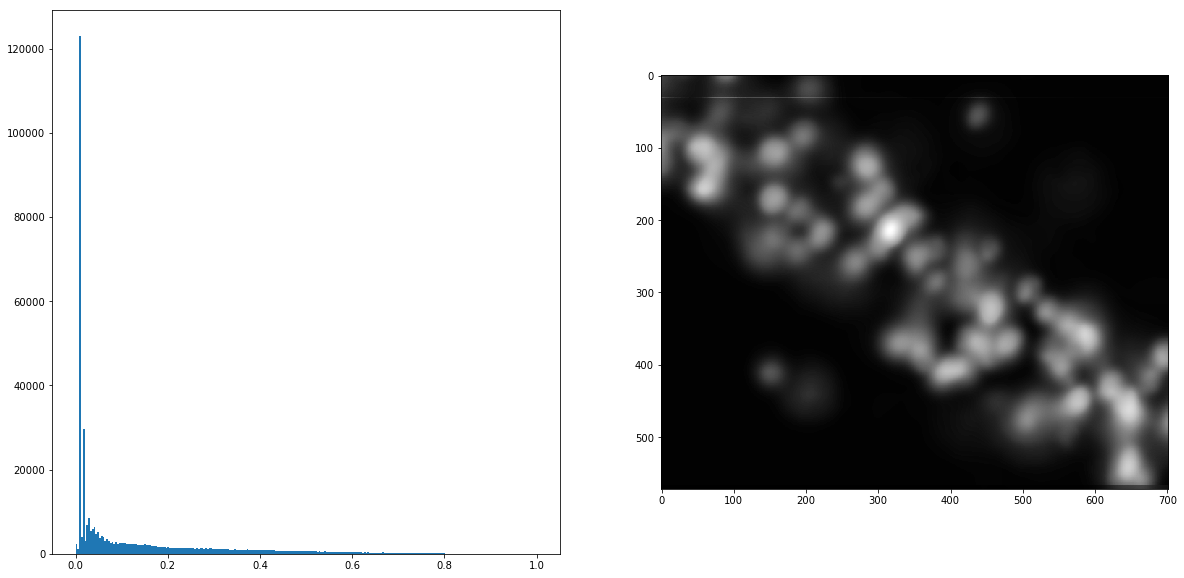

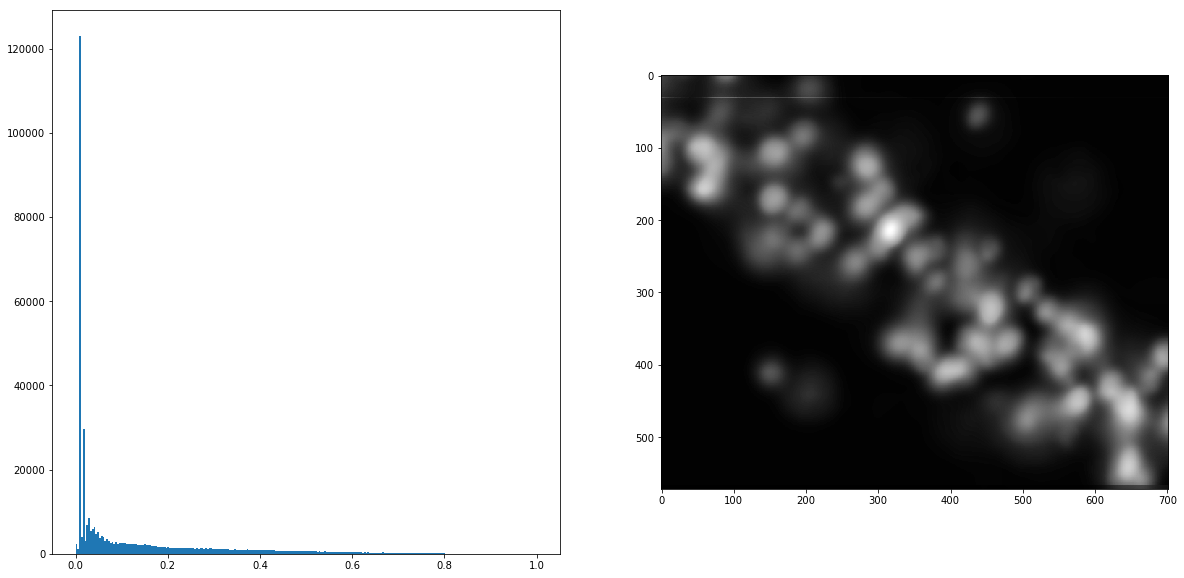

In [37]:
# test_blur_adeq = adapt_eq(test_blur_stack)
# test_blur_adeq_tst = adapt_eq(test_blur_stack, clip_limit=0.9)

# img_hist_stack(test_blur_adeq, 1)
# img_hist_stack(test_blur_adeq_tst, 1)

## Segmentation

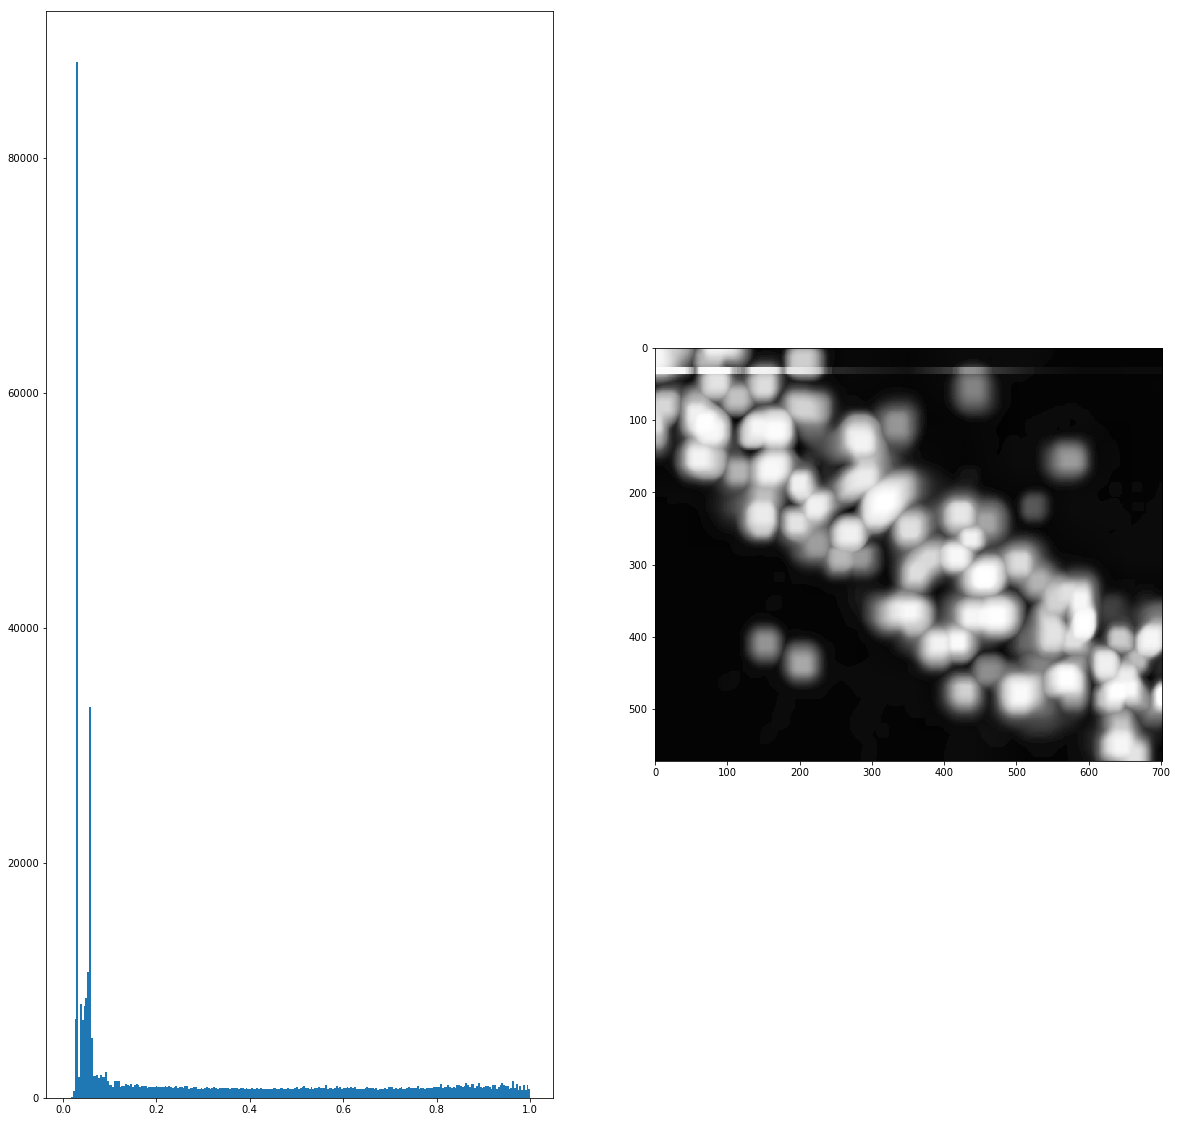

In [30]:
# ## finding local maxima

# img_max = ndi.maximum_filter(img_adapteq, size=10)

# img_hist(img_max)

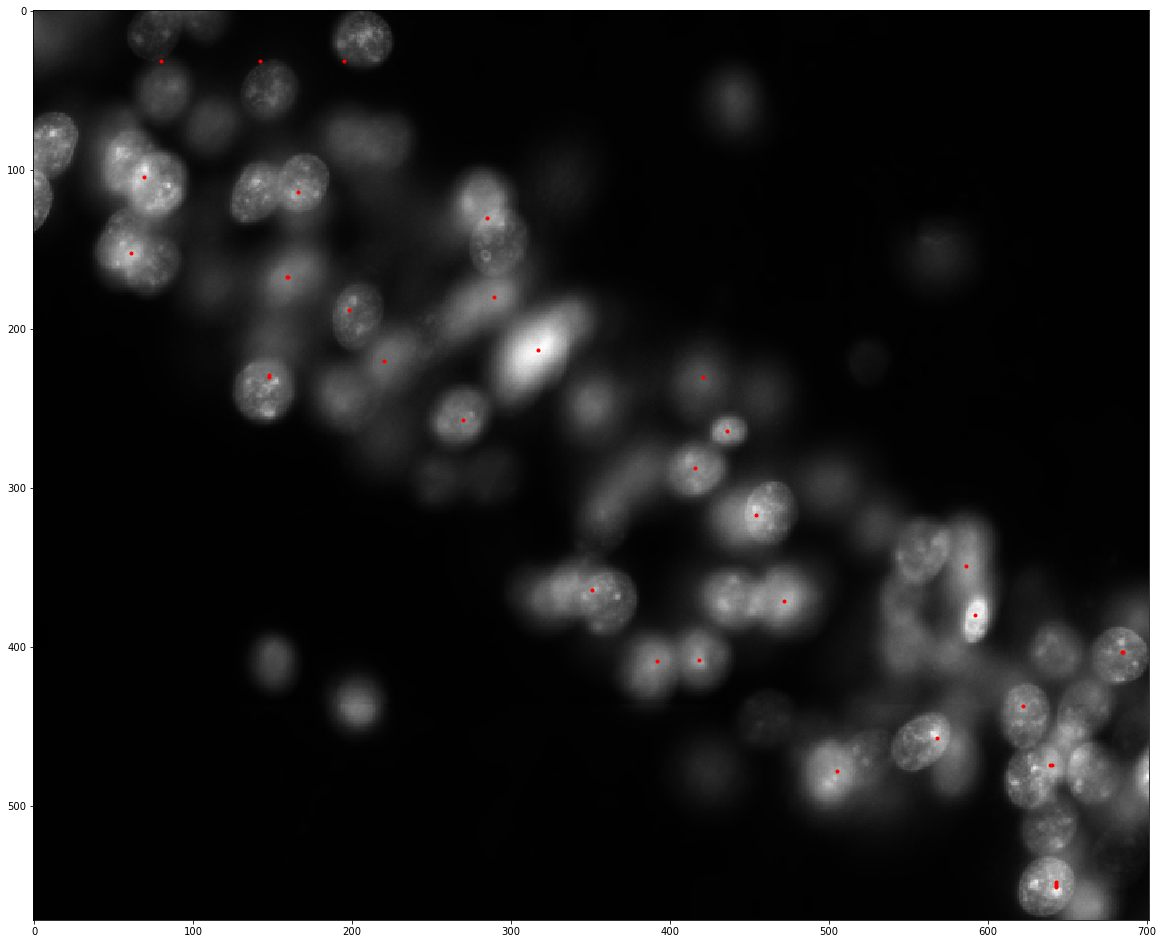

In [77]:
# seeds = peak_local_max(img_adapteq, min_distance=15, threshold_abs=0.9)

# f, ax = plt.subplots(1,1, figsize=(20,20));
# ax.imshow(img[9, :, :], cmap='gray');
# ax.plot(seeds[:, 1], seeds[:, 0], 'r.');

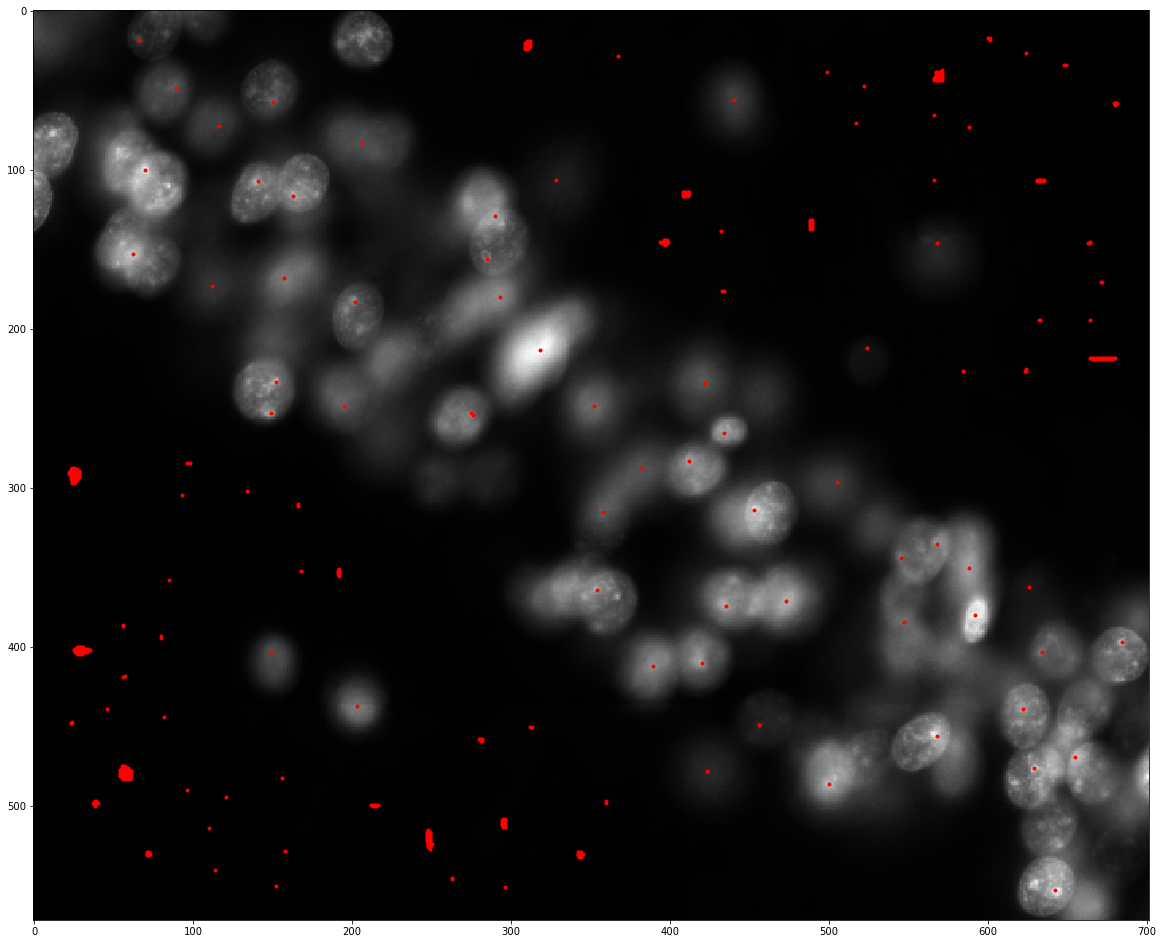

In [50]:
# img_coords = peak_local_max(img[9, :, :], min_distance=15)

# f, ax = plt.subplots(1,1, figsize=(20,20));
# ax.imshow(img[9, :, :], cmap='gray');
# ax.plot(img_coords[:, 1], img_coords[:, 0], 'r.');

In [53]:
# img[9, :, :].max()

10659

# Work in progress